In [39]:

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

Importing Data

In [40]:

fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [41]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

 Concatenating title and text of news
 
News has to be classified based on the tile and text jointly. Treating the title and content of news separately doesn't reap us any benefit

In [42]:

fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)


true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)


'''fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]'''

"fake_news = fake_news[['subject', 'date', 'news','output']]\ntrue_news = true_news[['subject', 'date', 'news','output']]"

 Converting the date columns to datetime format


In [43]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

In [44]:
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

Converting the date column to datetime format

In [45]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

Merging the datasets


In [46]:
dat = [fake_news, true_news]
news_dataset = pd.concat(dat)
news_dataset

,subject,date,output,news
0,News,2017-12-31,0,Donald Trump Sends Out Embarrassing New Year’...
1,News,2017-12-31,0,Drunk Bragging Trump Staffer Started Russian ...
2,News,2017-12-30,0,Sheriff David Clarke Becomes An Internet Joke...
3,News,2017-12-29,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,News,2017-12-25,0,Pope Francis Just Called Out Donald Trump Dur...
...,...,...,...,...
21412,worldnews,2017-08-22,1,'Fully committed' NATO backs new U.S. approach...
21413,worldnews,2017-08-22,1,LexisNexis withdrew two products from Chinese ...
21414,worldnews,2017-08-22,1,Minsk cultural hub becomes haven from authorit...
21415,worldnews,2017-08-22,1,Vatican upbeat on possibility of Pope Francis ...


Removing the punctuations

In [47]:
#Creating a copy 
clean_news=news_dataset.copy()

Make text lowercase, remove text in square brackets, remove links, remove punctuation, and remove words containing numbers.

In [48]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [49]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,output,news
0,News,2017-12-31,0,donald trump sends out embarrassing new year’...
1,News,2017-12-31,0,drunk bragging trump staffer started russian ...
2,News,2017-12-30,0,sheriff david clarke becomes an internet joke...
3,News,2017-12-29,0,trump is so obsessed he even has obama’s name...
4,News,2017-12-25,0,pope francis just called out donald trump dur...


Removing Stop Words


In [50]:
stop_words = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
clean_news.head()

,subject,date,output,news
0,News,2017-12-31,0,donald trump sends embarrassing new year’s eve...
1,News,2017-12-31,0,drunk bragging trump staffer started russian c...
2,News,2017-12-30,0,sheriff david clarke becomes internet joke thr...
3,News,2017-12-29,0,trump obsessed even obama’s name coded website...
4,News,2017-12-25,0,pope francis called donald trump christmas spe...


Deriving new features :

1. Polarity: The measure which signifies the sentiment of th news
2. Review length: Length of the news(number of letters and spaces)
3. Word Count: Number of words in the news

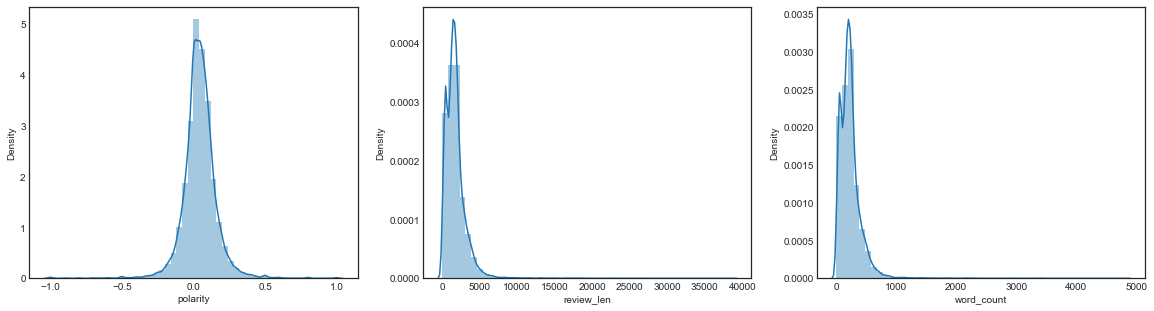

In [51]:
#Extracting new features
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

Looking at 20 most frequently used words in articles

In [52]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


Looking at most frequently used 2-word pairs in news articles

In [53]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')


donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512
said statement 4425
fox news 4074
president obama 4065
islamic state 4014
national security 3858



Stemming & Vectorizing



In [54]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [55]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [56]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

 TFIDF(Term Frequency — Inverse Document Frequency)


In [57]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 10000)

As we have considered 1000 words, we can confirm that we have 5000 columns from the shape.

In [58]:
#Getting the target variable
y=clean_news['output']

### Checking for balance of data
We should be careful about when handling imbalance data. If it is imbalanced, the model will be biased towards the higher frequency class and returns max output

In [59]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


Our dataset is nearly a balanced one. So let's leave balancing it.

## Train-test split (70:30)
Using train test split function we are splitting the dataset into 70:30 ratio for train and test set respectively.

In [60]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


<a id="section-five"></a>
# Model Building: Fake News Classifier
As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model Selection
First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

**Note:** I'm not including SVM in this algorithm because it took alot of time to train in my device

In [62]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=15, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9716852319702599
Decision Tree Test Accuracy: 0.9373108107866661
KNN Test Accuracy: 0.5752143519072727
Naive Bayes Test Accuracy: 0.9422352021025887


From the results, we can see logistic regression outdone the rest of the algorithms followed by Naive Bayes and Decision Tree.That's great. So let's go with logistic regression with hyperparameter tuning.

## Logistic Regression with Hyperparameter Tuning
We use regularization parameter and penality for parameter tuning. let's see which one to plug.

In [63]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=24.420530945486497, random_state=0)
The mean accuracy of the model is: 0.984183559812876


From the selected params, we get accuracy. Let's plug and chug

In [64]:
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


We have got 98% accuracy. As already discussed before this is a biased dataset and we can easily get such higher accuracy without any effort in processing it. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy

### Confusion Matrix
Let's look at the true positive and true negative classified by the model

Confusion matrix, without normalization


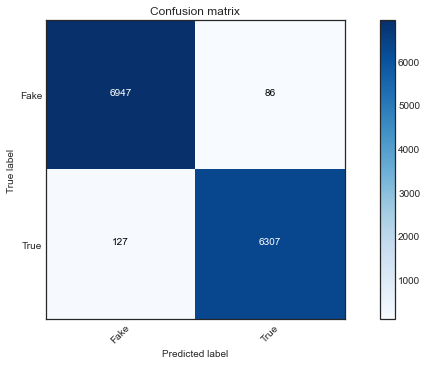

In [65]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

Check out the diagonal elements(5799+5202), they are correctly predicted records and rest are incorrectly classified by the algorithm. Our model has done well(results are good by the data is biased :P)

### Classification Report
Considering Fake news, we should seriously consider precision score (False positive). We can't afford the mistakes when the model classifies fake news as true which will lead to chaos

In [66]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      7033
           1       0.99      0.98      0.98      6434

    accuracy                           0.98     13467
   macro avg       0.98      0.98      0.98     13467
weighted avg       0.98      0.98      0.98     13467



All our scores are 98%. Certainly unreal to get such values. There are only changes in the support.

## ROC-AUC Curve

This is a very important curve where we decide on which threshold to setup based upon the objective criteria

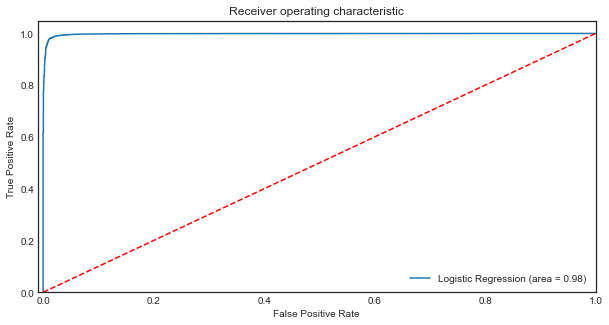

In [67]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

We should consider the AUC score here which is 98%. Very well. All metrics are performing good. The more far left the curve is better our model We can adjust our threshold based on our ROC curve to get results based on model requirements

<a id="section-six"></a>
# Deep learning-LSTM
Here in this part we use neural network to predict whether the given news is fake or not.


We aren't gonna use normal neural network like ANN to clasify but LSTM(long short term memory) which helps in containing sequence information.Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more.


## One hot for Embedding layers
Before jumping into creating a layer let's take some vocabulary size. There might be a question why vocabulary size ? it is because we will be one hot encoding the sentences in the corpus for embedding layers. While onehot encoding the words in sentences will take the index from the vocabulary size. Let's fix the vocabulary size to 10000

In [68]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [69]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

We can see all the words in the sentences are transformed into their index from the vocabulary we created.

## Padding embedded documents
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our LSTM model, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary. Here we take the common length as 10000 and perform padding using pad_sequence() function . Also we are going to 'pre' pad so that zeros are added before the sentences to make the sentence of equal length

In [70]:
#Setting sentence length
sent_length=10000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2714 1653 4050]
 [   0    0    0 ... 4166 8867 4050]
 [   0    0    0 ... 4972  702 4050]
 ...
 [   0    0    0 ... 3215 1485 8463]
 [   0    0    0 ... 1168 6483  838]
 [   0    0    0 ... 5102 9297 2000]]


In [71]:
embedded_docs[1]

array([   0,    0,    0, ..., 4166, 8867, 4050])

We can see all the sentences are of equal length with the addition of zeros infront of the sentences and making all the sentences of length 5000

## LSTM Model
At first we are going to develop the base model and compile it. The first layer will be the embedding layer which has the input of vocabulary size, vector features and sentence length. Later we add 30% dropout layer to prevent overfitting and the LSTM layer which has 100 neurons in the layer.In final layer we use sigmoid activation function. Later we compile the model using adam optimizer and binary cross entropy as loss function since we have only two outputs.

To understand how LSTM works please check this [link](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). To give a small overview on how LSTM works,it remembers only the important sequence of words and forgets the insignificant words which doesn't add value in the prediction

In [72]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(200)) #Adding 200 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 40)         400000    
                                                                 
 dropout_2 (Dropout)         (None, 10000, 40)         0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               192800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 593,001
Trainable params: 593,001
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
len(embedded_docs),y.shape

(44888, (44888,))

## Fitting the LSTM Model
Before fitting to the model, let's consider the padded embedded object as X and y as y itself and convert them into an array.

In [74]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 10000), (44888,))

Let's split our new X and y variable into train and test and proceed with fitting the model to the data. We have considered 10 epochs and 64 as batch size. It can be varied to get better results.

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

## Evaluation of model
Now, let's predict the output for our test data and evaluate the predicted values with y_test

Confusion matrix, without normalization


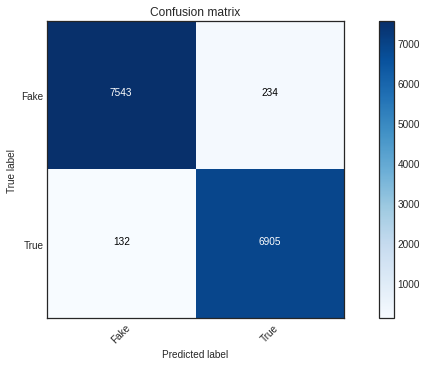

In [ ]:
# Predicting from test data
y_pred=model.predict_classes(X_test)

#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

0.9752936411502633

We have got an accuracy of 96%. That's awesome !

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7777
           1       0.97      0.98      0.97      7037

    accuracy                           0.98     14814
   macro avg       0.98      0.98      0.98     14814
weighted avg       0.98      0.98      0.98     14814



From the classification report we can see the accuracy value is nearly around 96%. We have to concentrate on precision score and it is 96% which is great.

## Bidirectional LSTM

Bi-LSTM is an extension of normal LSTM with two independent RNN's together. The normal LSTM is uni directional where it cannot know the future words whereas in Bi-LSTM we can predict the future use of words as there is a backward information passed on from the other RNN layer in reverse. 

There is only one change made in the code compared to the LSTM, here we use Bidirectional() function and call LSTM inside.

In [ ]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(200))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 40)          400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


## Fitting and Evaluation of Model
Let's now fit the bidirectional LSTM model to the data we have with the same parameters we had before

In [ ]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 254s 541ms/step - loss: 0.1919 - accuracy: 0.9310 - val_loss: 0.0789 - val_accuracy: 0.9748
Epoch 2/10
470/470 [==============================] - 265s 564ms/step - loss: 0.1207 - accuracy: 0.9620 - val_loss: 0.4134 - val_accuracy: 0.8544
Epoch 3/10
470/470 [==============================] - 274s 582ms/step - loss: 0.2030 - accuracy: 0.9230 - val_loss: 0.1069 - val_accuracy: 0.9642
Epoch 4/10
470/470 [==============================] - 273s 581ms/step - loss: 0.0963 - accuracy: 0.9646 - val_loss: 0.1214 - val_accuracy: 0.9522
Epoch 5/10
470/470 [==============================] - 273s 580ms/step - loss: 0.0593 - accuracy: 0.9804 - val_loss: 0.0862 - val_accuracy: 0.9716
Epoch 6/10
470/470 [==============================] - 272s 579ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.0942 - val_accuracy: 0.9706
Epoch 7/10
470/470 [==============================] - 271s 576ms/step - loss: 0.1135 - accuracy: 0.9580 - val_loss: 0.1020 -

Confusion matrix, without normalization


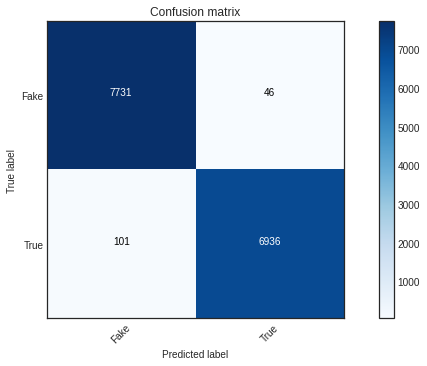

In [ ]:
# Predicting from test dataset
y_pred1=model1.predict_classes(X_test)

#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred1)

0.9900769542324828

We have got an accuracy of 98%. That's better than LSTM !

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7777
           1       0.99      0.99      0.99      7037

    accuracy                           0.99     14814
   macro avg       0.99      0.99      0.99     14814
weighted avg       0.99      0.99      0.99     14814



From the classification report we can see the accuracy value is nearly around 98%. We have to concentrate on precision score and it is 98%